<a href="https://colab.research.google.com/github/yudam-J/AI-2024/blob/main/multilabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 기본 모듈
import os
import sys
import json
import re
import urllib.request
from glob import glob
from collections import Counter
import importlib

# 데이터 처리
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt

# Colab
from google.colab import drive

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

# HuggingFace Transformers
from transformers import AutoModel, AutoTokenizer
from torch.optim import AdamW

# 평가 및 지표
from sklearn.metrics import (
    f1_score, roc_auc_score, recall_score,
    accuracy_score, precision_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split

# 진행바
from tqdm.auto import tqdm

pd.set_option('display.float_format', '{:.0f}'.format)
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-abob4cgg/kobert-tokenizer_446fc41e82c6450bb0a40735312f30d3
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-abob4cgg/kobert-tokenizer_446fc41e82c6450bb0a40735312f30d3
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 5c46b1c68e4755b54879431bd302db621f4d2f47
  Preparing metadata (setup.py) ... done
  Created wheel for kobert_tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4633 sha256=7f717cdf05921fc8bcede26f1e41450439f97a557828a6daf270ef9f842c53ff
  Stored in directory: /tmp/pip-ephem-wheel-cache-llrrhffv/wheels/b7/95/7c/3f38b039ae9422cc4a51702b37e352d0585442cbe60285f1f2
Successfully built kobert_tokenizer


In [2]:
final_df = pd.read_csv('/content/final_df.csv', encoding = 'utf-8', low_memory=False)

In [3]:
final_df['KDC_NM'] = final_df['KDC_NM'].astype(str).str.strip().str.replace(" ", "", regex=True)
final_df['KDC_NM'] = final_df['KDC_NM'].astype(str)

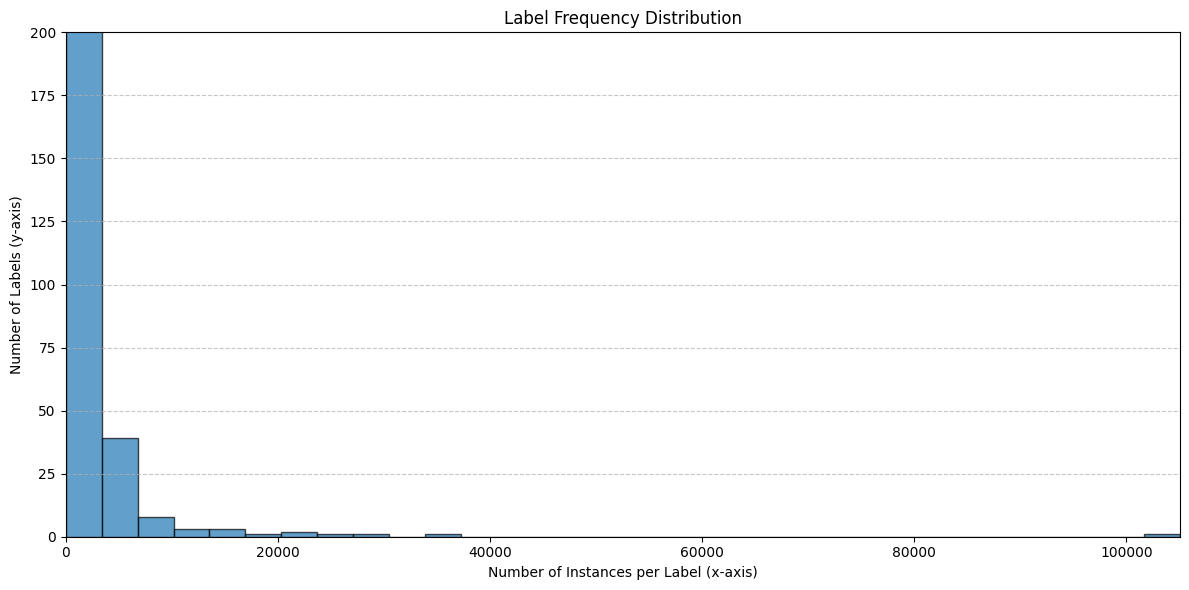

In [4]:
# 각 라벨의 빈도수 계산
label_counts = Counter(final_df['KDC_NM'])

# 라벨의 빈도수 (x축에 해당)
label_frequencies = list(label_counts.values())

# 적절한 bin 개수 결정 (빈도수의 분포를 기준으로)
n_bins = int(np.sqrt(len(label_frequencies)))  # 빈도수에 대해 제곱근 법칙 적용

# 라벨 빈도수로 히스토그램 구간 설정
plt.figure(figsize=(12, 6))

# 히스토그램 그리기
plt.hist(
    label_frequencies,  # 라벨 빈도수 사용
    bins=n_bins,  # 동적으로 계산된 bin 개수
    edgecolor='black',
    alpha=0.7
)

# x축 최대값을 label_frequencies의 최댓값으로 설정
plt.xlim(0, max(label_frequencies))
plt.ylim(0, 200)

# 그래프 설정
plt.title('Label Frequency Distribution')
plt.xlabel('Number of Instances per Label (x-axis)')
plt.ylabel('Number of Labels (y-axis)')

# x축에 라벨 빈도수 표시, y축에는 레이블 개수 표시
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # 레이아웃 조정
plt.show()

In [5]:
# 각 고유 라벨의 개수 세기
label_counts = final_df['KDC_NM'].value_counts()

# 평균, 최대, 최소, 중간값 구하기
mean_count = label_counts.mean()
max_count = label_counts.max()
min_count = label_counts.min()
median_count = label_counts.median()  # 중간값 계산

# 결과 출력
print(f"라벨 개수의 평균: {mean_count}")
print(f"라벨 개수의 최대값: {max_count}")
print(f"라벨 개수의 최소값: {min_count}")
print(f"라벨 개수의 중간값: {median_count}")

라벨 개수의 평균: 917.074
라벨 개수의 최대값: 105047
라벨 개수의 최소값: 1
라벨 개수의 중간값: 83.0


In [6]:
final_df.shape

(917074, 4)

In [7]:
final_df.head()

,TITLE_NM,ISBN_THIRTEEN_NO,KDC_NM,description
0,반 고흐,9788988950050,651,어린이들을 위한 서양미술 입문서 '화가의 마을' 시리즈 3권. 벨기에의 카스테르망(...
1,의사결정 불변의 법칙,9788958610038,325,의사결정에 대한 전략서. 일상생활 속에서 일어나는 다양한 실제 사례를 통해 인간이 ...
2,공주를 키워주는 회사는 없다,9788982736964,325,간단하게 말해서 이 책은 우선 직장에서 살아남고 그 다음에 성공으로 가는 방법을 알...
3,중국의 제4물결,9788947524223,341,"13억 중국을 이끌어갈 후진타오와 4세대 지도자 우방궈 전인대 상무위원장, 완자바오..."
4,"(공병호의)10년 후, 세계",9788973376414,321,"으로 한국사회의 변화의 필요성을 역설하며 큰 반향을 불러일으켰던 공병호 박사, 그는..."


In [8]:
# 하이퍼파라미터
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LENGTH = 202
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
GRAD_ACCUMULATION_STEPS = 4
NUM_EPOCHS = 5
PATIENCE = 3  # early stopping 기준

In [9]:
# 데이터셋 정의
class BookDataset(Dataset):
    def __init__(self, data, tokenizer, max_length, label_dicts):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_dicts = label_dicts
        self.level_dims = {
            level: len(label_dicts[level]) for level in ['level1', 'level2', 'level3']
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        input_text = item['TITLE_NM'] + " " + item['description']
        encoding = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        labels = {}
        for level in ['level1', 'level2', 'level3']:
            label_idx = self.label_dicts[level].get(str(item[level]), 0)
            label_vector = torch.zeros(self.level_dims[level])
            label_vector[label_idx] = 1.0
            labels[level] = label_vector

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': labels
        }


class CascadingBERTMultiLabelClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(CascadingBERTMultiLabelClassifier, self).__init__()
        self.bert = bert_model
        self.num_classes = num_classes

        # 각 레벨별 fully connected layer
        self.fc1 = nn.Linear(self.bert.config.hidden_size, num_classes['level1'])
        self.fc2 = nn.Linear(self.bert.config.hidden_size + num_classes['level1'], num_classes['level2'])
        self.fc3 = nn.Linear(self.bert.config.hidden_size + num_classes['level2'], num_classes['level3'])

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token

        # Level 1
        level1_logits = self.fc1(cls_output)                      # shape: (batch, level1_classes)
        level1_probs = torch.sigmoid(level1_logits)              # sigmoid → multilabel

        # Level 2
        level2_input = torch.cat([cls_output, level1_probs], dim=-1)
        level2_logits = self.fc2(level2_input)
        level2_probs = torch.sigmoid(level2_logits)

        # Level 3
        level3_input = torch.cat([cls_output, level2_probs], dim=-1)
        level3_logits = self.fc3(level3_input)
        level3_probs = torch.sigmoid(level3_logits)

        return {
            'level1_logits': level1_logits,
            'level2_logits': level2_logits,
            'level3_logits': level3_logits,
            'level1_probs': level1_probs,
            'level2_probs': level2_probs,
            'level3_probs': level3_probs
        }


# KDC 코드 레벨 분해
final_df['KDC_NM'] = final_df['KDC_NM'].astype(str)
final_df["level1"] = final_df["KDC_NM"].apply(lambda x: x[:1] + "00" if len(x) >= 1 else "000")
final_df["level2"] = final_df["KDC_NM"].apply(lambda x: x[:2] + "0" if len(x) >= 2 else "000")
final_df["level3"] = final_df["KDC_NM"].apply(lambda x: x if len(x) >= 3 else "000")

# 레이블 딕셔너리 생성
label_dicts = {
    level: {str(k): v for v, k in enumerate(sorted(final_df[level].unique()))}
    for level in ['level1', 'level2', 'level3']
}

# 토크나이저 및 데이터셋 생성
tokenizer = AutoTokenizer.from_pretrained("skt/kobert-base-v1")
dataset = BookDataset(final_df, tokenizer, MAX_LENGTH, label_dicts)

# 학습/검증/테스트 분할
indices = list(range(len(dataset)))
train_indices, temp_indices = train_test_split(indices, test_size=0.2, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# 라벨 분포 시각화
def plot_label_distribution(train_labels, val_labels, test_labels):
    plt.figure(figsize=(12, 4))
    for i, (labels, title) in enumerate(zip(
        [train_labels, val_labels, test_labels],
        ['Train Label Distribution', 'Validation Label Distribution', 'Test Label Distribution']
    )):
        plt.subplot(1, 3, i+1)
        plt.hist(labels, bins=np.arange(min(labels), max(labels)+1, 1), edgecolor='black', alpha=0.7)
        plt.title(title)
        plt.xlabel('Label')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

train_labels = [torch.argmax(sample['labels']['level3']).item() for sample in train_dataset]
val_labels = [torch.argmax(sample['labels']['level3']).item() for sample in val_dataset]
test_labels = [torch.argmax(sample['labels']['level3']).item() for sample in test_dataset]

# 클래스 가중치 계산
from collections import Counter

# level3 라벨 인덱스 리스트 생성
level3_label_indices = [
    torch.argmax(sample['labels']['level3']).item() for sample in train_dataset
]

# 개수 카운팅
label_counts = Counter(level3_label_indices)
num_classes = len(label_dicts['level3'])
total_samples = len(train_dataset)

default_count = sum(label_counts.values()) / len(label_counts)  # 평균 등장 수

class_weights = [
    total_samples / (num_classes * label_counts.get(i, default_count))
    for i in range(num_classes)
]


# 텐서 변환
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

In [10]:
from torch.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

# 학습 함수
def train_model(model, train_loader, val_loader, optimizer, loss_fns, device, num_epochs, patience, threshold=0.5):
    scaler = GradScaler()
    model.to(device)
    best_val_loss = float("inf")
    early_stopping_counter = 0

    train_losses, val_losses = [], []
    train_f1s, val_f1s = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        all_preds = {"level1": [], "level2": [], "level3": []}
        all_labels = {"level1": [], "level2": [], "level3": []}

        train_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False)
        for batch in train_tqdm:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = {k: v.to(device) for k, v in batch['labels'].items()}

            optimizer.zero_grad()
            with autocast(device_type='cuda'):
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = 0
                for level in ['level1', 'level2', 'level3']:
                    logits = outputs[f"{level}_logits"]
                    target = labels[level]
                    loss += loss_fns[level](logits, target)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()

            for level in ['level1', 'level2', 'level3']:
                probs = torch.sigmoid(outputs[f"{level}_logits"]).detach().cpu().numpy()
                preds = (probs > threshold).astype(int)
                targets = labels[level].cpu().numpy()
                all_preds[level].extend(preds)
                all_labels[level].extend(targets)

            train_tqdm.set_postfix(loss=loss.item())

        train_losses.append(total_loss / len(train_loader))
        micro_f1 = sum([f1_score(all_labels[l], all_preds[l], average='micro', zero_division=0) for l in all_preds]) / 3
        train_f1s.append(micro_f1)

        val_loss, val_f1 = evaluate_model(model, val_loader, loss_fns, device, threshold)
        val_losses.append(val_loss)
        val_f1s.append(val_f1)

        print(f"Epoch {epoch+1} - Train Loss: {train_losses[-1]:.4f}, F1: {train_f1s[-1]:.4f} | Val Loss: {val_loss:.4f}, F1: {val_f1:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pt")
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping triggered!")
                break

    plot_training_curves(train_losses, val_losses, train_f1s, val_f1s)


# 평가 함수
def evaluate_model(model, dataloader, loss_fns, device, threshold=0.5):
    model.eval()
    total_loss = 0
    all_preds = {"level1": [], "level2": [], "level3": []}
    all_labels = {"level1": [], "level2": [], "level3": []}

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = {k: v.to(device) for k, v in batch['labels'].items()}

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = 0
            for level in ['level1', 'level2', 'level3']:
                logits = outputs[f"{level}_logits"]
                target = labels[level]
                loss += loss_fns[level](logits, target)

                probs = torch.sigmoid(logits).cpu().numpy()
                preds = (probs > threshold).astype(int)
                all_preds[level].extend(preds)
                all_labels[level].extend(target.cpu().numpy())

            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    avg_f1 = sum([f1_score(all_labels[l], all_preds[l], average='micro', zero_division=0) for l in all_preds]) / 3
    return avg_loss, avg_f1


# 테스트 평가 함수
def test_model(model, test_loader, device, threshold=0.5):
    model.eval()
    all_preds, all_labels, all_probs = {}, {}, {}
    for level in ['level1', 'level2', 'level3']:
        all_preds[level] = []
        all_labels[level] = []
        all_probs[level] = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = {k: v.cpu().numpy() for k, v in batch['labels'].items()}

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            for level in ['level1', 'level2', 'level3']:
                probs = torch.sigmoid(outputs[f"{level}_logits"]).cpu().numpy()
                preds = (probs > threshold).astype(int)

                all_preds[level].extend(preds)
                all_probs[level].extend(probs)
                all_labels[level].extend(labels[level])

    return evaluate_test_metrics(all_preds, all_labels, all_probs)


# 테스트 메트릭 출력
def evaluate_test_metrics(all_preds, all_labels, all_probs):
    metrics = {}
    for level in all_preds:
        metrics[level] = {
            "Subset Accuracy": accuracy_score(all_labels[level], all_preds[level]),
            "Micro F1": f1_score(all_labels[level], all_preds[level], average="micro", zero_division=0),
            "Macro F1": f1_score(all_labels[level], all_preds[level], average="macro", zero_division=0),
            "Micro Precision": precision_score(all_labels[level], all_preds[level], average="micro", zero_division=0),
            "Macro Precision": precision_score(all_labels[level], all_preds[level], average="macro", zero_division=0),
            "Micro Recall": recall_score(all_labels[level], all_preds[level], average="micro", zero_division=0),
            "Macro Recall": recall_score(all_labels[level], all_preds[level], average="macro", zero_division=0),
        }

    print("\n📊 Test Performance:")
    for level, results in metrics.items():
        print(f" - {level.upper()}:")
        for metric, value in results.items():
            print(f"   {metric}: {value:.4f}")
    return metrics


# 학습 시각화 함수
def plot_training_curves(train_losses, val_losses, train_f1s, val_f1s):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", marker="o")
    plt.plot(val_losses, label="Val Loss", marker="o")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_f1s, label="Train Micro F1", marker="o")
    plt.plot(val_f1s, label="Val Micro F1", marker="o")
    plt.title("Micro F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("F1")
    plt.legend()

    plt.tight_layout()
    plt.show()

config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

Epoch 1/5 - Training:   0%|          | 0/22927 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

Epoch 1 - Train Loss: 0.2691, F1: 0.2501 | Val Loss: 0.2194, F1: 0.3263


Epoch 2 - Train Loss: 0.2107, F1: 0.3350 | Val Loss: 0.2032, F1: 0.3627


Epoch 3 - Train Loss: 0.1932, F1: 0.3693 | Val Loss: 0.1926, F1: 0.3867


Epoch 4 - Train Loss: 0.1799, F1: 0.3938 | Val Loss: 0.1874, F1: 0.4064


Epoch 5 - Train Loss: 0.1688, F1: 0.4147 | Val Loss: 0.1851, F1: 0.4188


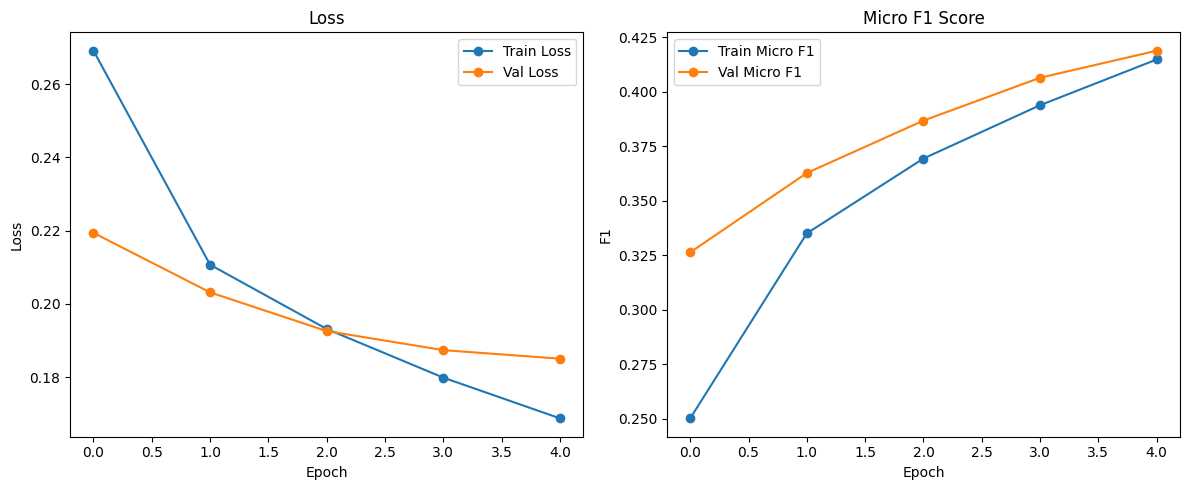

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# 모델 및 optimizer 정의
torch.cuda.empty_cache()
bert_model = AutoModel.from_pretrained("skt/kobert-base-v1")
num_classes = {
    'level1': len(label_dicts['level1']),
    'level2': len(label_dicts['level2']),
    'level3': len(label_dicts['level3']),
}
model = CascadingBERTMultiLabelClassifier(bert_model, num_classes).to(DEVICE)

loss_fns = {
    "level1": nn.BCEWithLogitsLoss(),
    "level2": nn.BCEWithLogitsLoss(),
    "level3": nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)  # level3만 클래스 불균형 보정
}

optimizer = AdamW(model.parameters(), lr=2e-5)

train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fns=loss_fns,
    device=DEVICE,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE
)

model.load_state_dict(torch.load("best_model.pt"))
test_metrics = test_model(model, test_loader, DEVICE)

In [ ]:
model.load_state_dict(torch.load("best_model.pt"))
test_metrics = test_model(model, test_loader, DEVICE)


📊 Test Performance:
 - LEVEL1:
   Subset Accuracy: 0.6124
   Micro F1: 0.6956
   Macro F1: 0.5387
   Micro Precision: 0.8014
   Macro Precision: 0.6765
   Micro Recall: 0.6144
   Macro Recall: 0.4615
 - LEVEL2:
   Subset Accuracy: 0.4001
   Micro F1: 0.5281
   Macro F1: 0.1832
   Micro Precision: 0.7632
   Macro Precision: 0.3373
   Micro Recall: 0.4038
   Macro Recall: 0.1442
 - LEVEL3:
   Subset Accuracy: 0.0179
   Micro F1: 0.0351
   Macro F1: 0.0086
   Micro Precision: 0.4739
   Macro Precision: 0.0222
   Micro Recall: 0.0182
   Macro Recall: 0.0125


Epoch 1 - Train Loss: 0.1591, F1: 0.4311 | Val Loss: 0.1809, F1: 0.4265


Epoch 2 - Train Loss: 0.1499, F1: 0.4489 | Val Loss: 0.1855, F1: 0.4382


Epoch 3 - Train Loss: 0.1412, F1: 0.4667 | Val Loss: 0.1872, F1: 0.4620
Early stopping triggered!


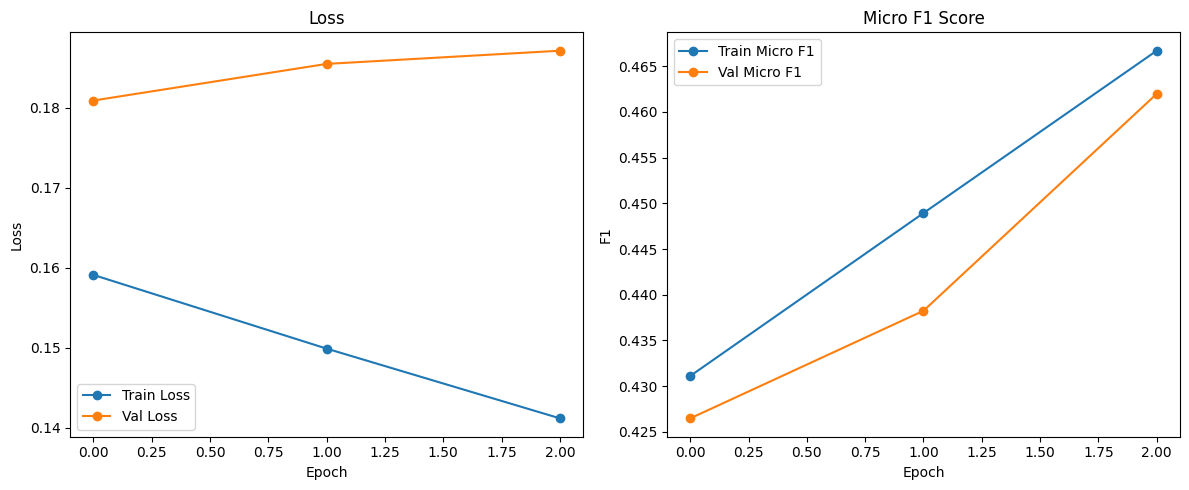


📊 Test Performance:
 - LEVEL1:
   Subset Accuracy: 0.6133
   Micro F1: 0.7011
   Macro F1: 0.5487
   Micro Precision: 0.8169
   Macro Precision: 0.6921
   Micro Recall: 0.6140
   Macro Recall: 0.4647
 - LEVEL2:
   Subset Accuracy: 0.3995
   Micro F1: 0.5327
   Macro F1: 0.1881
   Micro Precision: 0.7944
   Macro Precision: 0.3731
   Micro Recall: 0.4007
   Macro Recall: 0.1461
 - LEVEL3:
   Subset Accuracy: 0.0261
   Micro F1: 0.0506
   Macro F1: 0.0061
   Micro Precision: 0.8492
   Macro Precision: 0.0198
   Micro Recall: 0.0261
   Macro Recall: 0.0047


In [12]:
# 모델 및 optimizer 정의
torch.cuda.empty_cache()
bert_model = AutoModel.from_pretrained("skt/kobert-base-v1")
num_classes = {
    'level1': len(label_dicts['level1']),
    'level2': len(label_dicts['level2']),
    'level3': len(label_dicts['level3']),
}
model = CascadingBERTMultiLabelClassifier(bert_model, num_classes).to(DEVICE)

loss_fns = {
    "level1": nn.BCEWithLogitsLoss(),
    "level2": nn.BCEWithLogitsLoss(),
    "level3": nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)  # level3만 클래스 불균형 보정
}

# ░1️⃣ 기존 모델 불러오기
model.load_state_dict(torch.load("best_model (9).pt"))

model.to(DEVICE)

# ░2️⃣ 이어서 학습할 optimizer 재설정 (필요하면 scheduler도)
optimizer = AdamW(model.parameters(), lr=2e-5)

# ░3️⃣ 이어 학습을 위한 설정
additional_epochs = 5  # 추가로 몇 에폭 더 학습할지 정함
new_patience = 2       # 조기 종료용 patience

# ░4️⃣ 이어서 학습 실행
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fns=loss_fns,
    device=DEVICE,
    num_epochs=additional_epochs,
    patience=new_patience
)

# ░5️⃣ 이어 학습 후 최종 테스트
model.load_state_dict(torch.load("best_model.pt"))
test_metrics = test_model(model, test_loader, DEVICE)

In [ ]:
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing for Confusion Matrix"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels']['level3'].to(device)

        # autocast는 AMP 환경에서만 사용 (선언 안 되어 있다면 생략 가능)
        # with autocast():
        _, _, logits = model(input_ids, attention_mask)

        preds = torch.argmax(logits, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Confusion Matrix 생성
conf_matrix = confusion_matrix(all_labels, all_preds)

# 클래스 이름 정렬 (level3 기준)
class_names = [k for k, _ in sorted(label_dicts['level3'].items(), key=lambda x: x[1])]

# 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d', xticks_rotation=90)
plt.title("Confusion Matrix (Level 3)")
plt.tight_layout()
plt.show()

In [ ]:
misclassified_pairs = list(zip(*top_misclassifications))
misclassified_pairs = sorted(
    misclassified_pairs,
    key=lambda pair: error_matrix[pair[0], pair[1]],
    reverse=True
)

for true_class, pred_class in misclassified_pairs:
    count = error_matrix[true_class, pred_class]
    if count > 0:
        print(f"True: {class_names[true_class]}, Predicted: {class_names[pred_class]}, Count: {count}")